# Particle Filter

This Jupyter Notebook is structured in two parts.

# First Part: PF concept

Demonstrates a functional - although limited - pf for WoFoSt.



In [1]:
from data_gen import DataGenerator
from kalmanWoFost import KalmanWofostDA
import numpy as np
from matplotlib import pyplot as plt
import scipy
import datetime as dt
import pandas as pd

dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value   
N = 100

# General utility functions for PF

def particles(ensemble_size,range1=(150.,50.),range2=(4.5,1.5),range3=(31,3),range4=(0.31,0.03)):
    '''
    Fonction qui permet de définir les particules de départ. Elles eront utilisée pour la data assimilation.
    '''
    override_parameters = {}
    # Initial conditions
    override_parameters["TDWI"] = np.random.normal(range1[0],range1[1], (ensemble_size))
    override_parameters["WAV"] = np.random.normal(range2[0],range2[1], (ensemble_size))
    # parameters
    override_parameters["SPAN"] = np.random.normal(range3[0],range3[1] ,(ensemble_size))
    override_parameters["SMFCF"] = np.random.normal(range4[0],range4[1],(ensemble_size))
    
    k = KalmanWofostDA(ensemble_size=ensemble_size, override_parameters=override_parameters)
    override_parameters = pd.DataFrame(override_parameters)
    particle_set = {k.ensemble[element]:dict(override_parameters.iloc[[element]]) for element in range(ensemble_size)}
    return particle_set

def get_particles_last_value(particle_set,days=0,STATE='LAI'):
    '''
    Permet de récupérer les valeurz des particules au dernier jour calculé
    '''
    for element in particle_set.keys():
        element.run(days)
    TEMP = [element.get_variable(STATE) for element in particle_set.keys()]
    return np.array(TEMP)

def predict(particle_set, days=1,date=None):
    '''
    Permet d'avancer dans le temps: cela permet de "prédire" l'état suivant du système.
    '''
    if date:
        for element in particle_set.keys():
            element.run_till(date)
    else:
        for element in particles:
            element.run(days)   

[0.13871329 0.08123333 0.12737567 0.14572576 0.10583548 0.14752182
 0.10355489 0.11321417 0.06219238 0.08065462 0.04504208 0.08015957
 0.16289054 0.05167314 0.15600542 0.0739471  0.07512357 0.11295159
 0.04520264 0.04944812 0.10831958 0.05371828 0.04232453 0.08634918
 0.06267972 0.11235437 0.05682687 0.11445765 0.16480517 0.07019536
 0.04671686 0.11028109 0.11855105 0.09778769 0.09524157 0.11666955
 0.05659402 0.07341083 0.08747754 0.1185199  0.0849189  0.09927371
 0.09230984 0.12463814 0.12838912 0.10677538 0.04475308 0.05823249
 0.09705857 0.10299953 0.13380922 0.107194   0.11482242 0.13107138
 0.14459205 0.1684719  0.13744519 0.12310699 0.1230236  0.15030561
 0.08389324 0.0404404  0.13764262 0.06622346 0.09107142 0.08716138
 0.08777738 0.09039618 0.04068674 0.13490003 0.12834119 0.08194272
 0.1458935  0.12306057 0.13470963 0.17466072 0.11738661 0.11051215
 0.09318275 0.03314575 0.08484395 0.13587123 0.10064161 0.16866259
 0.08857337 0.10157837 0.11920952 0.14172628 0.11489026 0.1086

In [3]:
def update(particle_set, weights, obs):
    """
    We need to do this in two steps:
    - move forward to next observation
    - update particles, weights accordingly
    """
    predict(particle_set, date=obs[0])
    curr_value  = get_particles_last_value(particle_set)
    w_distance  = np.abs(curr_value-obs[1])+ 1.e-300
    w_distance  = scipy.stats.norm(0,0.5).pdf(w_distance)
    weights    *= w_distance
    weights    /=  sum(weights)
    return weights


def plot_p(particle_set,weights,fig=plt):
    for index in range(len(particle_set)):
        fig.plot(pd.DataFrame(list(particle_set.keys())[index].get_output())['LAI'],color='black',alpha=weights[index])


## Below is an example of how to use the functions above
# weights = [1/len(my_particles)]*len(my_particles)
# fig, ax = plt.subplots(1,5,figsize=(25,5))
# for i in range(5):
#     weights = update(my_particles,weights,(dates_of_observation[i],observed_lai[i]))
#     print(max(weights),min(weights),sum(weights),np.array(weights).argmax())
#     plot_p(my_particles,weights,ax[i])
#     ax[i].scatter(len(pd.DataFrame(list(my_particles.keys())[0].get_output())['LAI']),observed_lai[i])






The functions below are the core of the PF, and it's advantage over pure brute-force: they allow for a more evolve evaluation of each particle and easier resampling of their capabilities.

In [ ]:
def estimate(particles,weights):
    pos = get_particles_last_value(particles)
    mean= np.average(pos,weights=weights)
    var = var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

def neff(weights):
    return 1. / np.sum(np.square(weights))

def index_resample(my_part,weights,indexes):
    keys = list(my_part.keys())
    top_particles = {keys[index]:my_part[keys[index]] for index in indexes}
    # we have the core particles. Let's add some more:
    # First, gather information on top particles:
    TDWIv = [my_part[keys[index]]['TDWI'] for index in indexes]
    WAVv = [my_part[keys[index]]['WAV'] for index in indexes]
    SPANv = [my_part[keys[index]]['SPAN'] for index in indexes]
    SMFCFv = [my_part[keys[index]]['SMFCF'] for index in indexes]
    today = list(pd.DataFrame(list(top_particles.keys())[0].get_output())['day'])[-1]
    # Now, let's add some more particles:
    new_particles = particles(ensemble_size=N-5, range1=(np.mean(TDWIv),np.std(TDWIv)/10),range2=(np.mean(WAVv),np.std(WAVv)/10),range3=(np.mean(SPANv),np.std(SPANv)/10),range4=(np.mean(SMFCFv),np.std(SMFCFv)/10))
    predict(new_particles, date=today)
    new_particles = top_particles | new_particles
    new_weights = np.zeros(len(new_particles))
    new_weights.fill(1.0/len(new_particles))
    return new_particles,new_weights

def get_five_top(weights):
    indexes = []
    d = weights.copy()
    for i in range(5):
        indexes.append(d.argmax())
        d[indexes[-1]] = 0
    return indexes


Here is an implementation of the PF filter for WoFoSt, using the previously defined functions.

In [ ]:
obs_pack = [(dates_of_observation[i],observed_lai[i],std_lai[i]) for i in range(5)]
No  = len(obs_pack)
N   = 10
my_part = particles(ensemble_size=N)
total_part = my_part.copy()
# my_part = np.array(my_part)
weights = [1/N]*N
print('particles initilalised')
alpha = .20
if N > 5000:
    alpha *= np.sqrt(5000)/np.sqrt(N)           
for element in my_part:
    element.run(1)
for obs in obs_pack:
    weights = update(my_part,weights,obs)
    plt.scatter(len(pd.DataFrame(list(my_part.keys())[0].get_output())['LAI']),obs[1])
    plot_p(my_part,weights)
    plt.plot()
    print(estimate(my_part,weights))
    if neff(weights)< N/2:
        print("Resampling...",neff(weights))
        indexes = get_five_top(weights)
        my_part, weights = index_resample(my_part,weights,indexes)
        print("Resampled values:",estimate(my_part,weights))
        total_part = total_part | my_part
        # indexes = sys_resample(weights)
        # print(indexes)
        # my_part, weights = index_resample(my_part,weights,indexes)
        # print(neff(weights))

In [ ]:
plot_p(total_part,[1]*len(total_part))
len(total_part)

# Second Part

Below, out PfWoFoSt module is introduced for more efficient and easier implementationof a PF filter.

=====[Assimilate] Currently on observation 1/5 with 100 particles
[Assimilate] Updated weights. Current LAI estimate:  (1.5211977664332554, 0.05461175906164745)
=====[Assimilate] Currently on observation 2/5 with 100 particles
[Assimilate] Updated weights. Current LAI estimate:  (3.91942955504146, 0.2593298866927589)
[Resampling] from neff 42.58933567718209
[Resampled] New ranges:  [(164.47091185073504, 50.0), (3.2225594382825724, 0.2000131224243741), (31.346051658374293, 1.0805040457255193), (0.3094394798599982, 6.857958289531644e-05)]
[Resampling] New estimate: (3.905086912840525, 0.1382431431540725)
=====[Assimilate] Currently on observation 3/5 with 100 particles
[Assimilate] Updated weights. Current LAI estimate:  (4.49436474389936, 0.03617794326476993)
[Resampling] from neff 1.945340445436483
[Resampled] New ranges:  [(132.36635567402675, 10.305291192644516), (6.5854206206665715, 0.013981924772461162), (32.21728992921082, 0.39270110354294385), (0.29394653411124466, 4.586450099164

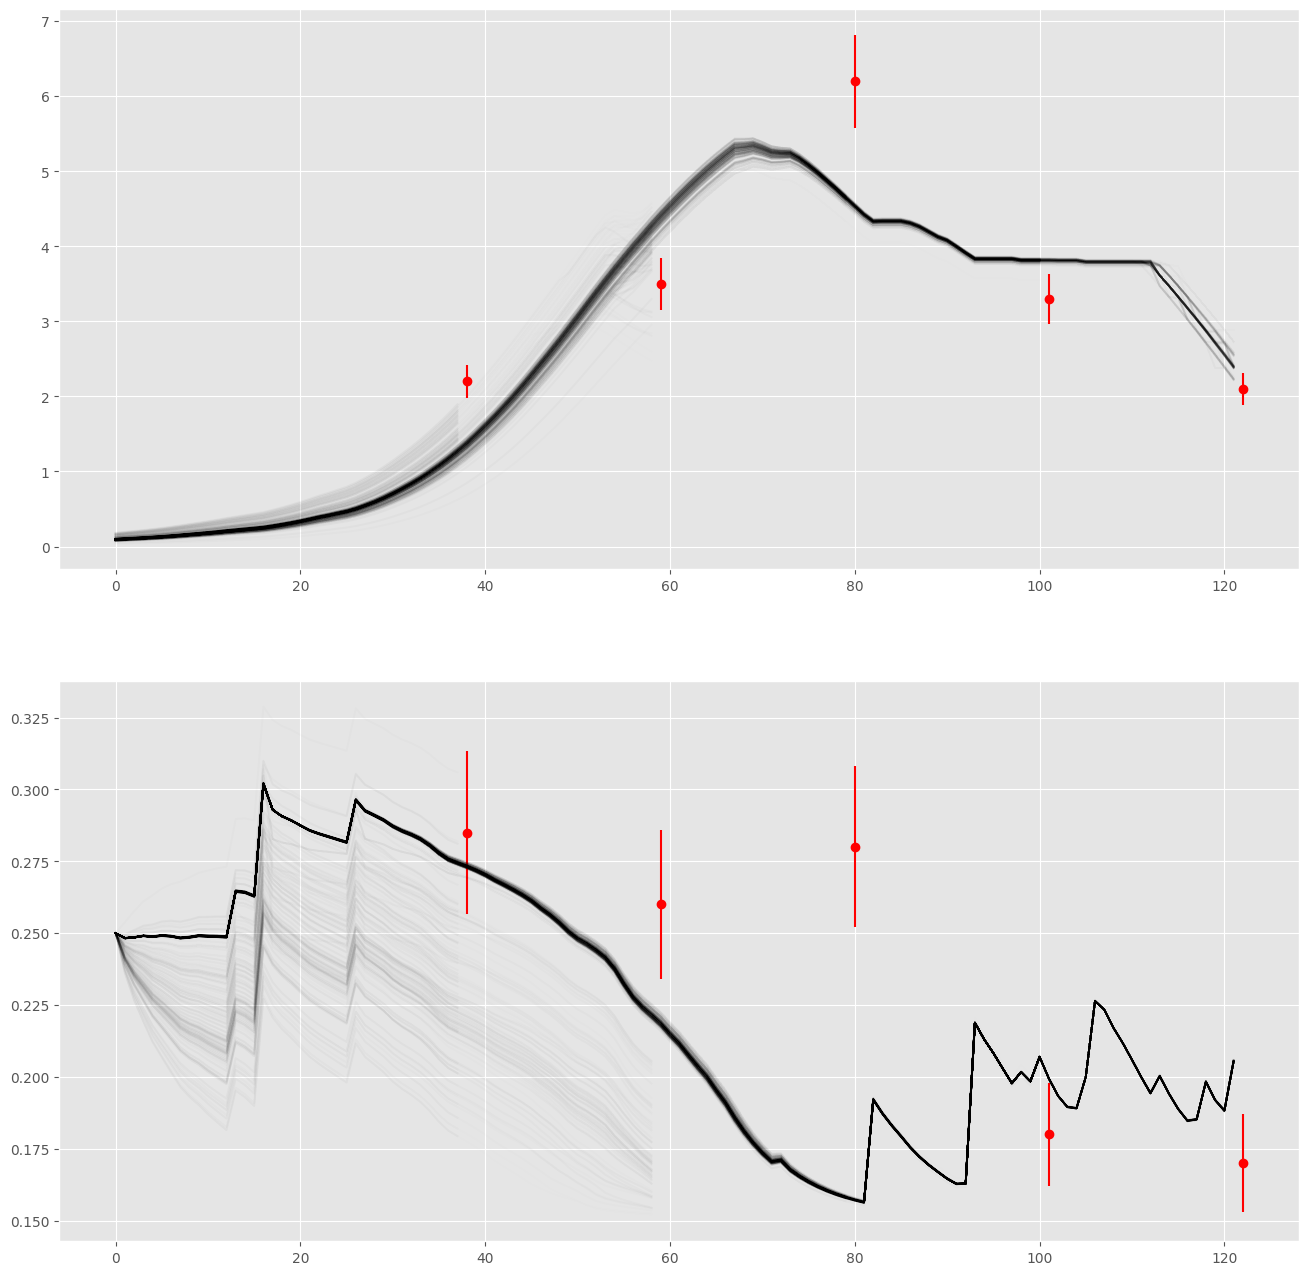

In [1]:
from PfWoFost import PfWoFost
import numpy as np
import datetime as dt

# override_parameters = {}
# # Initial conditions
# override_parameters["TDWI"] = np.random.normal(range1[0],range1[1], N)
# override_parameters["WAV"] = np.random.normal(range2[0],range2[1], N)
# # parameters
# override_parameters["SPAN"] = np.random.normal(range3[0],range3[1] ,N)
# override_parameters["SMFCF"] = np.random.normal(range4[0],range4[1],N)


dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
observed_sm = np.array([0.285, 0.26, 0.28, 0.18, 0.17])
std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value   
N = 100

range1=(150.,50.)
range2=(4.5,1.5)
range3=(31,3)
range4=(0.31,0.03)
obs_pack = [(dates_of_observation[i],observed_lai[i],observed_sm[i]) for i in range(5)]
No  = len(obs_pack)
pf = PfWoFost(ensemble_size=N,
              override_parameters=("TDWI","WAV","SPAN","SMFCF"),
              override_ranges=(range1,range2,range3,range4))
pf.get_particles_last_value()
pf.assimilate(obs_pack)

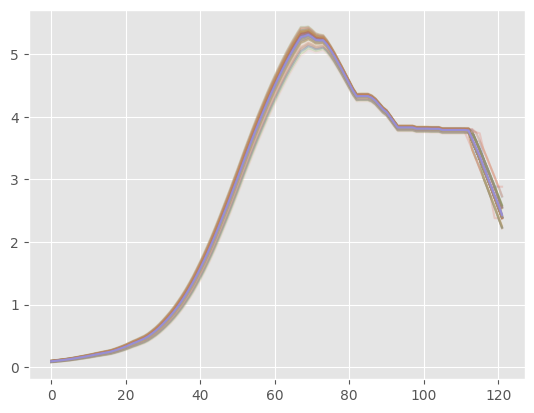

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
sum = pd.DataFrame()
for element in pf.particle_set:
    sum[element] = pd.DataFrame(element.get_output())['LAI']
    plt.plot(pd.DataFrame(element.get_output())['LAI'],alpha=0.2)
plt.plot(sum.sum(axis=1)/len(pf.particle_set))


No fig supplied.


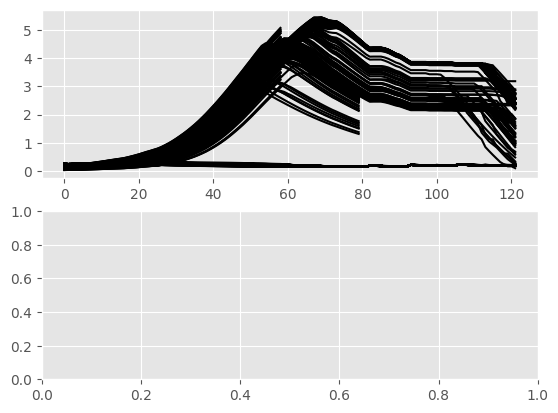

In [3]:
pf.plot_p(all=True)